In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PLOTS_FOLDER = "../plots"

RANDOM_SEED = 0

In [3]:
score_df = pd.read_csv(f"../data/tatoeba_train_opus_scores.tsv", sep="\t", index_col=0)

y = score_df.bleu

del score_df

In [4]:
def prep_data(path):
    df = pd.read_csv(path, sep="\t", index_col=0)
    unique_cnts = df.nunique(axis=0)
    const_feats = unique_cnts[unique_cnts == 1]
    df.drop(const_feats.index.tolist(), axis=1, inplace=True)
    return df

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

In [7]:
def get_metrics(alphas, X, y):
    X_train, X_test = X
    y_train, y_test = y

    r2s = []
    mses = []

    for alpha in alphas:
        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2s.append(r2_score(y_test, y_pred))
        mses.append(mean_squared_error(y_test, y_pred))

    return np.array(r2s), np.array(mses)

In [8]:
def plot_metrics(thresh, alphas, r2s, mses, additional_info="full"):
    plt.figure(figsize=(8, 6))

    sns.lineplot(x=alphas, y=r2s)

    ax = plt.gca()
    ax.set_xscale("log")
    ax.set(
        xlabel="Regularization coefficient", 
        ylabel="$ R^2 $",
        title=f"Metrics for linear regression\nTopological features, threshold {thresh}, {additional_info}"
    )

    ax.grid()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

    plt.show()

In [9]:
from functools import partial
from multiprocess.pool import Pool

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
def suppressed_vif(X, idx):
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return variance_inflation_factor(X, idx)

def calculate_vif_(X, thresh=5.0, verbose=False):
    pool = Pool(processes=8)
    variables = np.array(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif_func = partial(suppressed_vif, X.iloc[:, variables].values)
        args = list(range(X.iloc[:, variables].shape[1]))
        vif = pool.map(vif_func, args)

        vif = np.array(vif)
        if vif.max() > thresh:
            if verbose:
                print("dropping", X.columns[variables[vif == vif.max()]])
            variables = variables[vif < vif.max()]
            dropped = True

    pool.close()
    if verbose:
        print("Remaining variables:")
        print(X.columns[variables])
    return variables

In [12]:
import os
import sys

In [13]:
def train_linreg(path, alphas, n_samples=500):
    X = prep_data(path)

    common_index = X.index.intersection(y.index)

    X_train, X_test, y_train, y_test = train_test_split(X.reindex(common_index), y.reindex(common_index), random_state=RANDOM_SEED, test_size=0.4)
    del X

    used_vars = calculate_vif_(X_train.sample(n_samples))

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    r2s, mses = get_metrics(alphas, (X_train, X_test), (y_train, y_test))
    best_full_r2 = r2s.max()
    plot_metrics(thresh, alphas, r2s, mses, "full")

    r2s, mses = get_metrics(alphas, (X_train[:, used_vars], X_test[:, used_vars]), (y_train, y_test))
    best_cut_r2 = r2s.max()
    plot_metrics(thresh, alphas, r2s, mses, "VIF cut")

    return best_full_r2, best_cut_r2

### Ridge for vanilla topological features

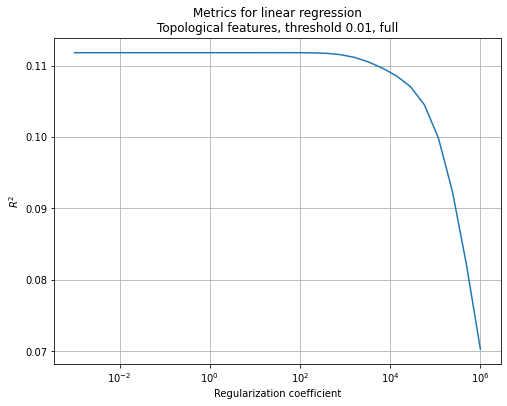

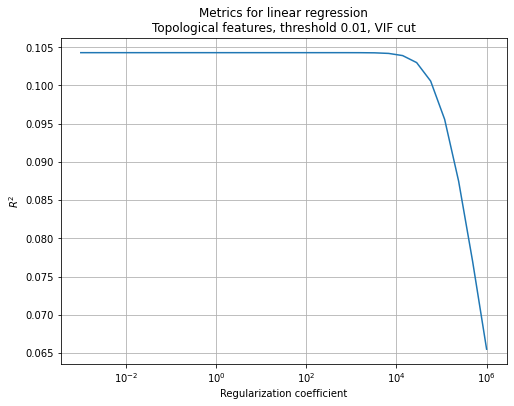

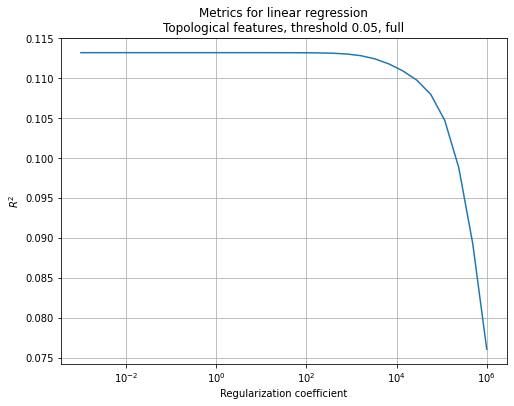

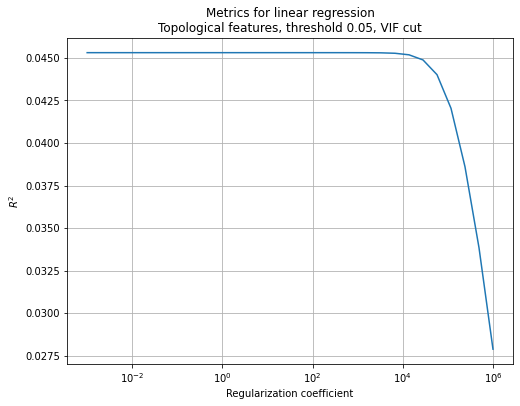

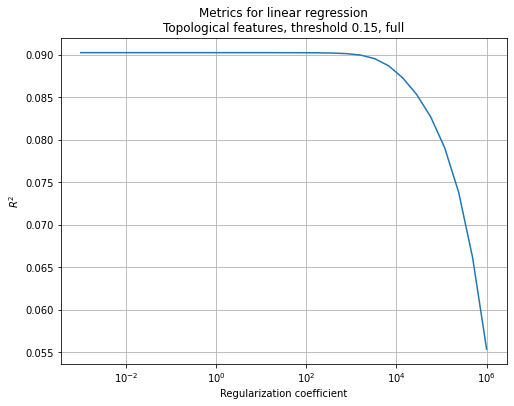

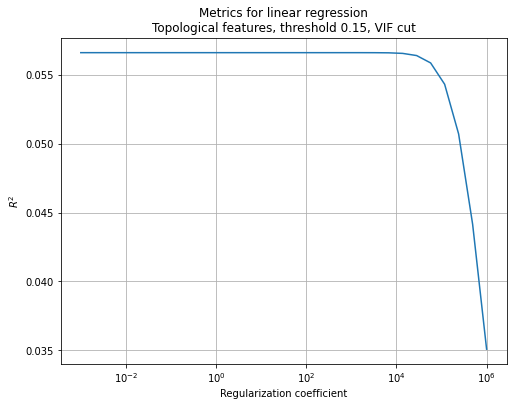

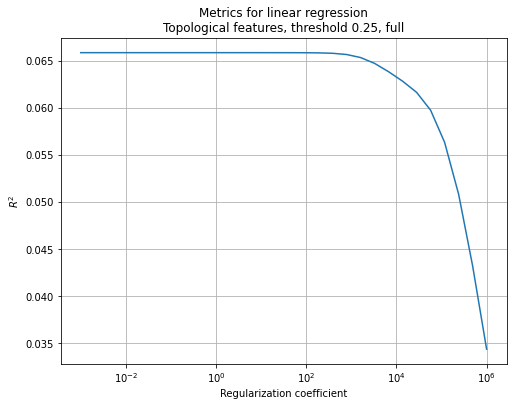

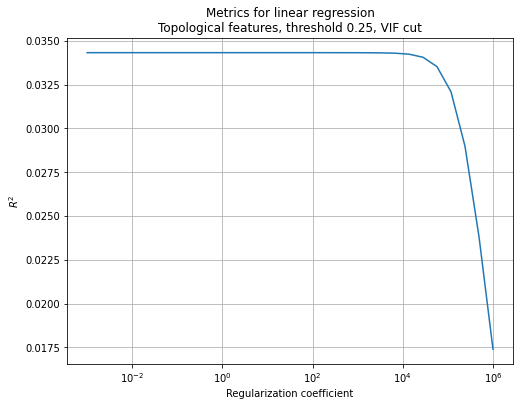

In [14]:
threshs = [0.01, 0.05, 0.15, 0.25]
alphas = np.logspace(-3, 6, num=30)

full_r2s = []
cut_r2s = []

for thresh in threshs:
    full_r2, cut_r2 = train_linreg(f"../data/tatoeba_tf_train_thresh{thresh}.tsv", alphas)
    full_r2s.append(full_r2)
    cut_r2s.append(cut_r2)

In [14]:
def plot_metrics_thresh(threshs, full_r2s, cut_r2s):
    plt.figure(figsize=(8, 12))

    plt.subplot(211)

    sns.lineplot(x=threshs, y=full_r2s)

    ax = plt.gca()
    ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")
    ax.grid()

    plt.subplot(212)

    sns.lineplot(x=threshs, y=cut_r2s)

    ax = plt.gca()
    ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")
    ax.grid()

    plt.show()

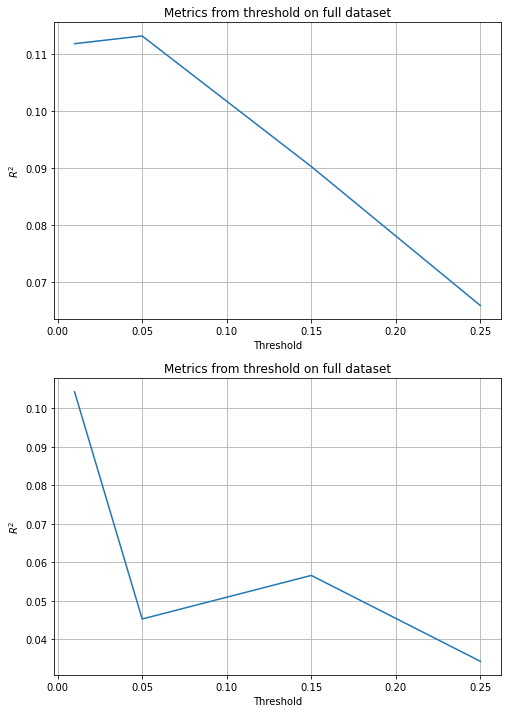

In [16]:
plot_metrics_thresh(threshs, full_r2s, cut_r2s)

In [17]:
from getpass import getpass
import mlflow

os.environ["MLFLOW_TRACKING_USERNAME"] = "no-brainer"
os.environ["MLFLOW_TRACKING_PASSWORD"] = getpass("Enter your DAGsHub access token: ")

mlflow.set_tracking_uri("https://dagshub.com/no-brainer/tda-mt.mlflow")

In [43]:
for i in range(len(threshs)):
    params = {
        "experiment_type": "bleu_prediction",
        "target_path": "../data/tatoeba_train_opus_scores.tsv",
        "train_test_split random_seed": RANDOM_SEED,
        "train_test_split test_size": 0.4,
        "features_path": f"../data/tatoeba_tf_train_thresh{thresh}.tsv",
        "thresh": threshs[i],
    }
    with mlflow.start_run():
        mlflow.log_metric("r2", full_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "full")
    
    with mlflow.start_run():
        mlflow.log_metrics("r2", cut_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "VIF cut")

### Ridge for features without special tokens

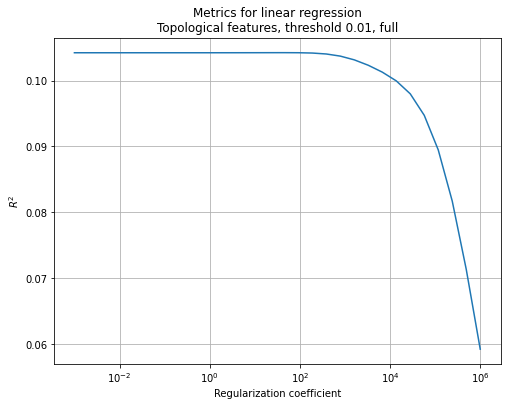

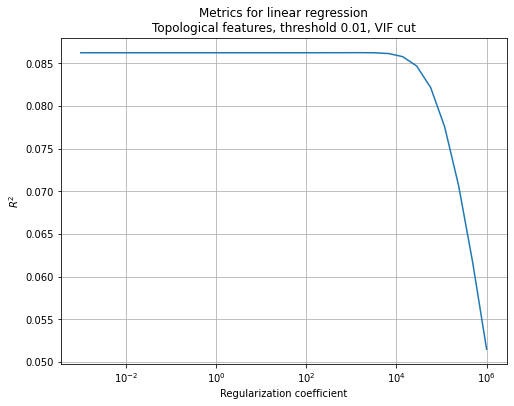

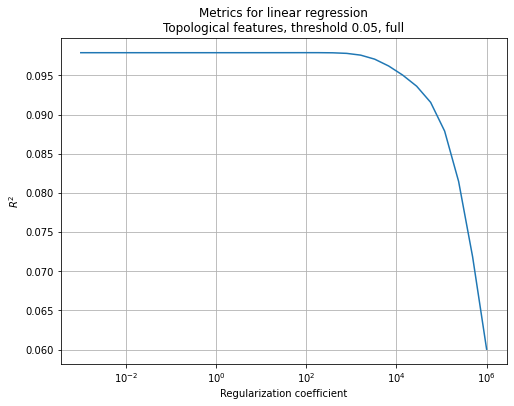

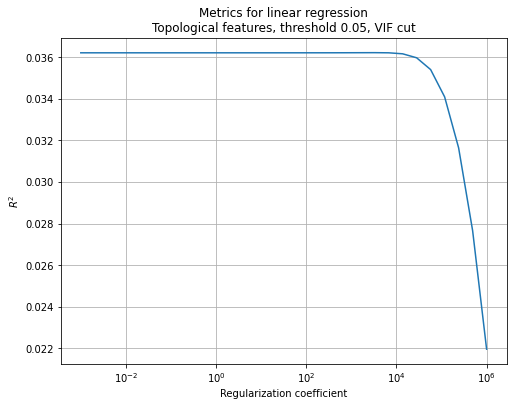

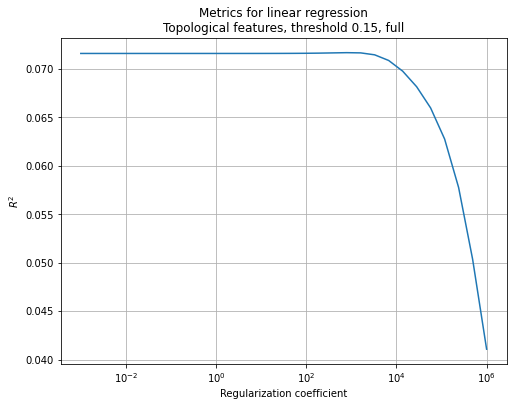

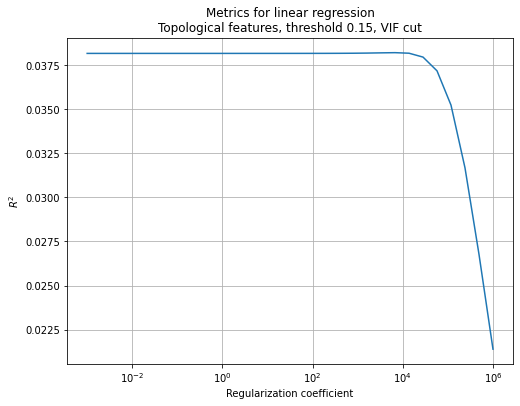

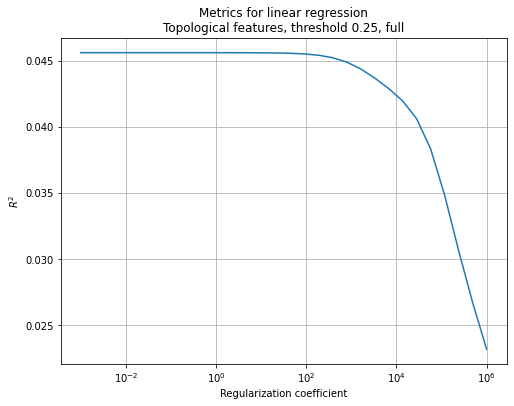

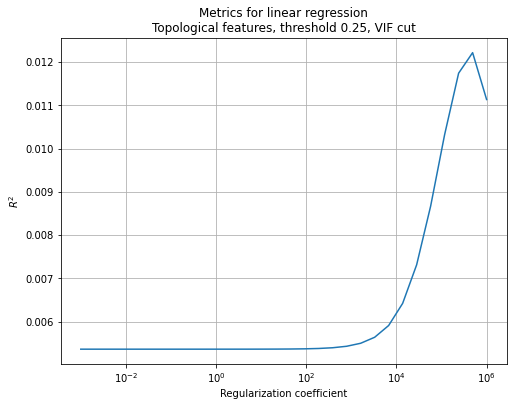

In [19]:
full_r2s = []
cut_r2s = []

for thresh in threshs:
    full_r2, cut_r2 = train_linreg(f"../data/tatoeba_tf_train_no_special_tokens_thresh{thresh}.tsv", alphas)
    full_r2s.append(full_r2)
    cut_r2s.append(cut_r2)

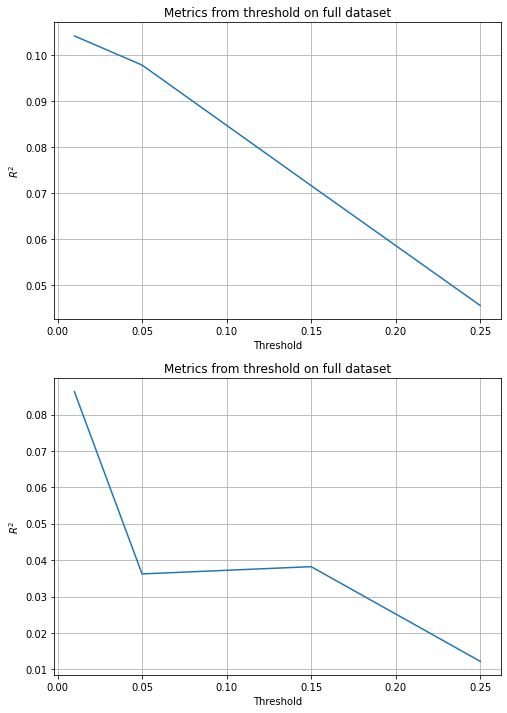

In [20]:
plot_metrics_thresh(threshs, full_r2s, cut_r2s)

In [ ]:
for i in range(len(threshs)):
    params = {
        "experiment_type": "bleu_prediction",
        "target_path": "../data/tatoeba_train_opus_scores.tsv",
        "train_test_split random_seed": RANDOM_SEED,
        "train_test_split test_size": 0.4,
        "features_path": f"../data/tatoeba_tf_train_no_special_tokens_thresh{thresh}.tsv",
        "thresh": threshs[i],
    }
    with mlflow.start_run():
        mlflow.log_metric("r2", full_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "full")
    
    with mlflow.start_run():
        mlflow.log_metrics("r2", cut_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "VIF cut")

### ElasticNet for vanilla topological features

In [15]:
from sklearn.linear_model import ElasticNet

In [16]:
def get_metrics(alphas, l1_ratios, X, y):
    X_train, X_test = X
    y_train, y_test = y

    r2s = []
    mses = []

    for alpha in alphas:
        for l1_ratio in l1_ratios:
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2s.append(r2_score(y_test, y_pred))
            mses.append(mean_squared_error(y_test, y_pred))

    shape = (len(alphas), len(l1_ratios))
    return np.array(r2s).reshape(shape), np.array(mses).reshape(shape)

In [17]:
def plot_metrics(thresh, alphas, l1_ratios, r2s, mses, additional_info="full"):
    alphas = list(map(lambda x: f"{x:.2f}", alphas))
    l1_ratios = list(map(lambda x: f"{x:.2f}", l1_ratios))

    plt.figure(figsize=(6, 8))

    scores = pd.DataFrame(r2s, index=alphas, columns=l1_ratios)
    sns.heatmap(scores, square=True)

    ax = plt.gca()
    ax.set(
        xlabel="Regularization coefficient", 
        ylabel="$ R^2 $",
        title=f"Metrics for linear regression\nTopological features, threshold {thresh}, {additional_info}"
    )

    ax.grid()
    plt.show()

In [18]:
def train_linreg(path, alphas, l1_ratios):
    X = prep_data(path)

    common_index = X.index.intersection(y.index)

    X_train, X_test, y_train, y_test = train_test_split(X.reindex(common_index), y.reindex(common_index), random_state=RANDOM_SEED, test_size=0.4)
    del X

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    r2s, mses = get_metrics(alphas, l1_ratios, (X_train, X_test), (y_train, y_test))
    best_full_r2 = r2s.max()
    plot_metrics(thresh, alphas, l1_ratios, r2s, mses, "full")

    return best_full_r2

In [21]:
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

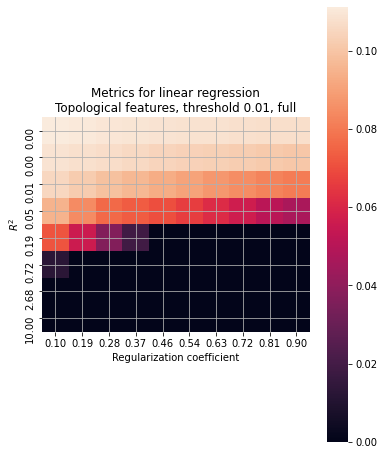

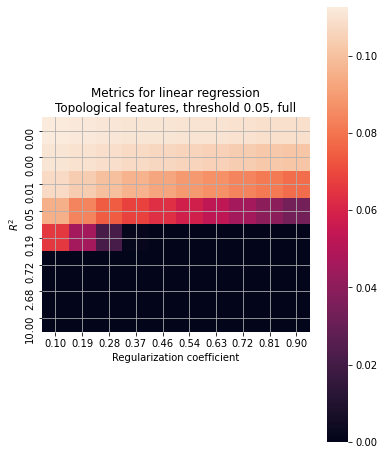

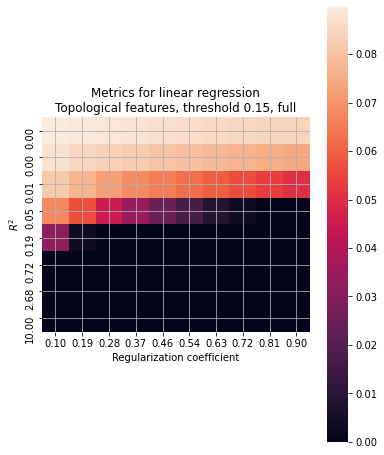

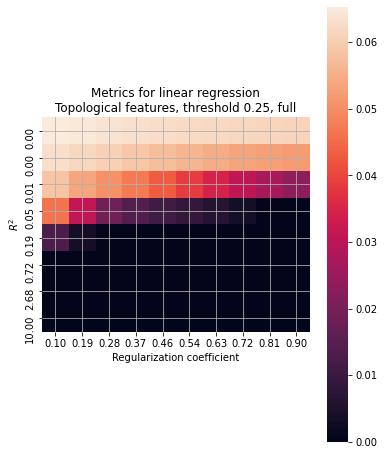

In [41]:
threshs = [0.01, 0.05, 0.15, 0.25]
alphas = np.logspace(-3, 1, num=8)
l1_ratios = np.linspace(0.1, 0.9, num=10)

full_r2s = []

for thresh in threshs:
    full_r2 = train_linreg(f"../data/tatoeba_tf_train_thresh{thresh}.tsv", alphas, l1_ratios)
    full_r2s.append(full_r2)

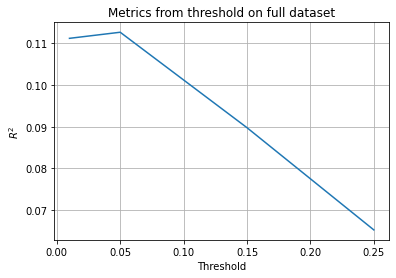

In [42]:
sns.lineplot(x=threshs, y=full_r2s)

ax = plt.gca()
ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")
ax.grid()

plt.show()

In [44]:
for i in range(len(threshs)):
    params = {
        "experiment_type": "bleu_prediction",
        "target_path": "../data/tatoeba_train_opus_scores.tsv",
        "train_test_split random_seed": RANDOM_SEED,
        "train_test_split test_size": 0.4,
        "features_path": f"../data/tatoeba_tf_train_thresh{thresh}.tsv",
        "thresh": threshs[i],
    }
    with mlflow.start_run():
        mlflow.log_metric("r2", full_r2s[i])
        mlflow.log_params(params)
        mlflow.log_param("data", "full")

## Analyze best model

In [16]:
X = prep_data("../data/tatoeba_tf_train_thresh0.05.tsv")

common_index = X.index.intersection(y.index)

X_train, X_test, y_train, y_test = train_test_split(X.reindex(common_index), y.reindex(common_index), random_state=RANDOM_SEED, test_size=0.4)
del X

In [17]:
cols = X_train.columns

In [18]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
model = Ridge(alpha=1.).fit(X_train_scaled, y_train)

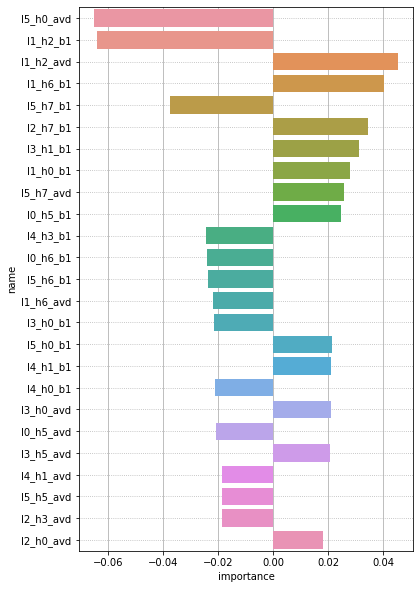

In [42]:
coef = model.coef_
idx = np.abs(coef).argsort()[-25:]
idx = idx[::-1]

data = pd.DataFrame(data=coef[idx], index=cols[idx]).reset_index()
data.columns = ["name", "importance"]

plt.figure(figsize=(6, 10))

sns.barplot(data=data, x="importance", y="name", zorder=100)

plt.gca().get_xaxis().grid()
plt.gca().get_yaxis().grid(linestyle=":")

plt.show()

In [48]:
"Variance of target variable: {:.6f}".format(y_train.var())

'Variance of target variable: 0.109947'

In [51]:
"Train score: {:.6f}".format(model.score(X_train_scaled, y_train))

'Train score: 0.113318'

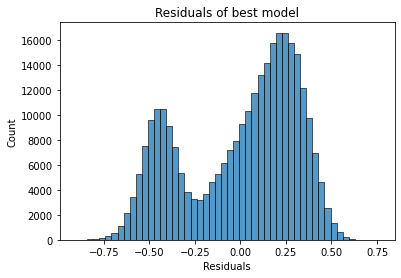

In [60]:
train_resid = model.predict(X_train_scaled) - y_train
train_resid.name = "Residuals"

sns.histplot(train_resid, bins=50)

plt.gca().set_title("Residuals of best model")

plt.show()

## Single heads

In [26]:
from itertools import product

In [27]:
alphas = np.logspace(-3, 1, num=15)
r2s = []

for layer, head in product(range(6), range(8)):
    features = [col for col in cols if col.startswith(f"l{layer}_h{head}")]
    model_scores = []
    for alpha in alphas:
        model = Ridge(alpha).fit(X_train[features], y_train)
        model_scores.append(model.score(X_test[features], y_test))
    r2s.append(np.max(model_scores))

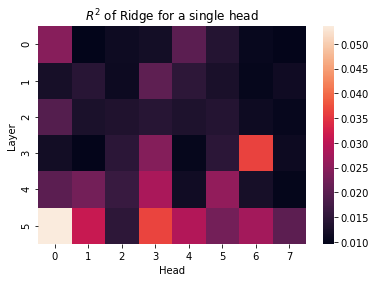

In [28]:
r2s = np.array(r2s).reshape(6, 8)

sns.heatmap(r2s)

plt.gca().set(
    title="$ R^2 $ of Ridge for a single head",
    xlabel="Head",
    ylabel="Layer",
)

plt.show()

## Dimensionality reduction

In [29]:
from sklearn.decomposition import PCA

In [33]:
n_comps = np.arange(2, X_train.shape[1], step=10)
r2s = []

for n_comp in n_comps:
    pca = PCA(n_components=n_comp).fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    model_scores = []
    for alpha in alphas:
        model = Ridge(alpha).fit(X_train_pca, y_train)
        model_scores.append(model.score(X_test_pca, y_test))
    r2s.append(np.max(model_scores))

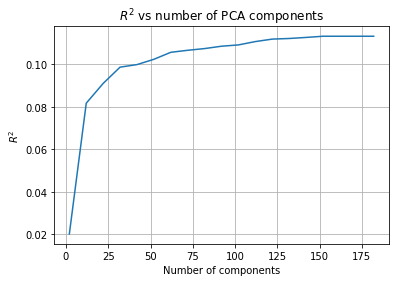

In [34]:
plt.plot(n_comps, r2s)

ax = plt.gca()
ax.set(
    title="$ R^2 $ vs number of PCA components",
    xlabel="Number of components",
    ylabel="$ R^2 $",
)
ax.grid()

plt.show()

## Correlation

In [85]:
from scipy import stats
import tqdm

In [90]:
def spearman_corr_cols(X, i, j):
    return stats.spearmanr(X[:, i], X[:, j]).correlation

In [91]:
spearman_corr = []
pool = Pool(processes=8)

args = product(range(len(cols)), repeat=2)
spearman_corr = pool.starmap(lambda i, j: spearman_corr_cols(X_train_scaled, i, j), args)

spearman_corr = np.array(spearman_corr).reshape(-1, len(cols))

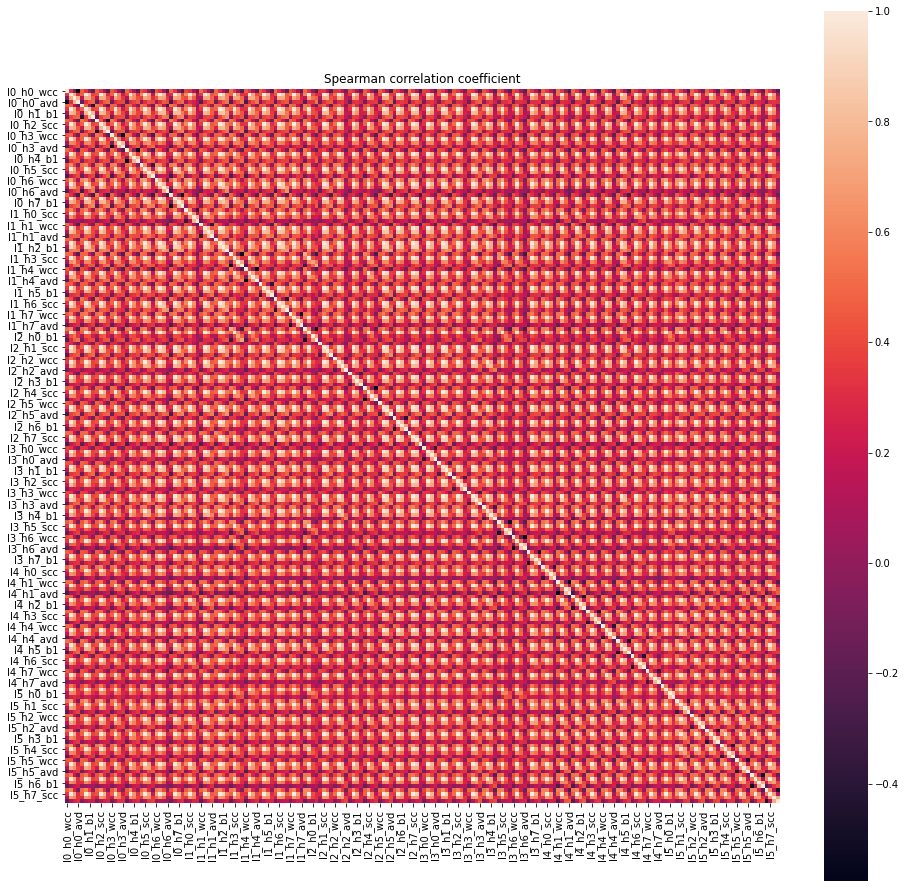

In [92]:
plt.figure(figsize=(16, 16))

data = pd.DataFrame(pearson_corr, index=cols, columns=cols)
sns.heatmap(data, square=True)

plt.gca().set_title("Spearman correlation coefficient")

plt.show()

## Binning

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [31]:
SEED = 1204

In [38]:
rng = np.random.default_rng(SEED)

idx_train = rng.choice(np.arange(X_train_scaled.shape[0]), size=100_000, replace=False)
idx_test = rng.choice(np.arange(X_test.shape[0]), size=50_000, replace=False)

X_subtrain_scaled = X_train_scaled[idx_train]
y_subtrain = y_train.values[idx_train]

X_subtest_scaled = X_test_scaled[idx_test]
y_subtest = y_test.values[idx_test]

In [40]:
bin_counts = [2, 5, 8, 12]
cs = np.logspace(-3, 1, num=15)

accuracies = []
f1s = []
best_c = []

for bin_count in bin_counts:
    bins = np.linspace(0, 1, bin_count + 1)[:-1]
    print(bins)
    y_train_digitized = np.digitize(y_subtrain, bins)
    y_test_digitized = np.digitize(y_subtest, bins)
    
    model_accs = []
    model_f1s = []
    for c in cs:
        model = LogisticRegression(C=c).fit(X_subtrain_scaled, y_train_digitized)
        y_preds = model.predict(X_subtest_scaled)
        model_accs.append((y_preds == y_test_digitized).mean())
        model_f1s.append(f1_score(y_test_digitized, y_preds, average="macro"))
    
    i = np.argmax(model_f1s)
    accuracies.append(model_accs[i])
    f1s.append(model_f1s[i])
    best_c.append(cs[i])

[0.  0.5]
[0.  0.2 0.4 0.6 0.8]
[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875]
[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667]


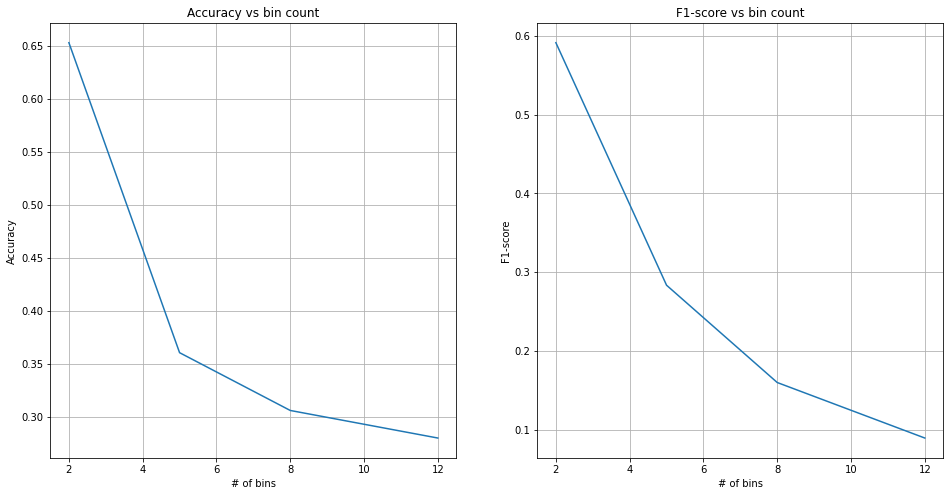

In [45]:
plt.figure(figsize=(16, 8))

plt.subplot(121)

plt.plot(bin_counts, accuracies)

ax = plt.gca()
ax.set(
    title="Accuracy vs bin count",
    xlabel="# of bins",
    ylabel="Accuracy",
)
ax.grid()

plt.subplot(122)

plt.plot(bin_counts, f1s)
ax = plt.gca()
ax.set(
    title="F1-score vs bin count",
    xlabel="# of bins",
    ylabel="F1-score",
)
ax.grid()

plt.show()

### Examine logistic regression

In [49]:
bins = np.linspace(0, 1, 2 + 1)[:-1]
y_train_digitized = np.digitize(y_subtrain, bins)
y_test_digitized = np.digitize(y_subtest, bins)

model = LogisticRegression(C=best_c[0]).fit(X_subtrain_scaled, y_train_digitized)
y_probs = model.predict_proba(X_subtest_scaled)

In [61]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresh = roc_curve(y_test_digitized, y_probs[:, 1], pos_label=2)
area = roc_auc_score(y_test_digitized, y_probs[:, 1])

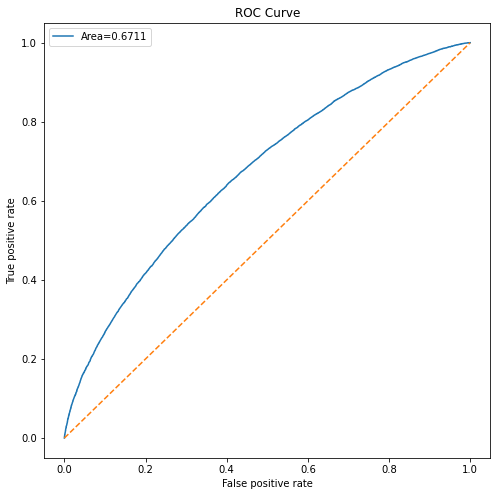

In [63]:
plt.figure(figsize=(8, 8))

plt.plot(fpr, tpr, label=f"Area={area:.4f}")
plt.plot([0, 1], [0, 1], color="tab:orange", linestyle="--")

ax = plt.gca()
ax.set(
    title="ROC Curve",
    xlabel="False positive rate",
    ylabel="True positive rate",
)
ax.legend()

plt.show()

### CatBoost

In [64]:
from catboost import CatBoostClassifier

In [66]:
model = CatBoostClassifier(task_type="GPU")
model.fit(X_subtrain_scaled, y_train_digitized, silent=True)

In [67]:
y_preds = model.predict(X_subtest_scaled)
(y_preds == y_test_digitized).mean()

0.65886